In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import helpers

sys.path.append(os.path.join('..'))
from adp.curve import * 
from adp.utility import *
from adp.plot import *
from adp.funcs import *

/Users/dinouye/anaconda3/envs/adp-env-3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
res = helpers.fetch_1980_data() 
orig_df = res['original_dataframe']
df = res['dataframe']
X = res['X']
y = res['y']
dtypes = res['dtypes']
feature_labels = res['feature_labels']

# Show stats
print(df.dtypes)
df.head()

WHITE         category
ALCHY         category
JUNKY         category
PAROLE        category
MARRIED       category
FELONY        category
WORKREL       category
PROPTY        category
PERSON        category
MALE          category
PRIORS         float64
SCHOOL         float64
RULE           float64
AGE (Year)     float64
TSERVD         float64
FOLLOW         float64
RECID         category
dtype: object


,WHITE,ALCHY,JUNKY,PAROLE,MARRIED,FELONY,WORKREL,PROPTY,PERSON,MALE,PRIORS,SCHOOL,RULE,AGE (Year),TSERVD,FOLLOW,RECID
1,1,0,0,1,0,1,0,1,0,1,0.0,10.0,1.0,19.333333,10.0,52.0,1
4,1,0,1,1,0,1,0,1,0,1,0.0,10.0,2.0,20.916667,23.0,46.0,0
5,1,0,1,0,0,1,0,1,0,1,0.0,11.0,0.0,22.750000,2.0,57.0,0
7,1,0,1,1,0,0,0,0,0,1,1.0,9.0,13.0,20.500000,36.0,46.0,1
9,0,0,1,0,0,0,1,0,0,1,1.0,11.0,4.0,24.666667,53.0,52.0,0


In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=0)
pipe = make_pipeline(
    OneHotEncoder(sparse=True, categorical_features=is_categorical(dtypes), handle_unknown='ignore'),
    StandardScaler(with_mean=False),
    SVC(),
    #LogisticRegression()
)
param_grid = {
    'svc__C': np.logspace(-1, 1, 10),
    'svc__gamma': np.logspace(-3, 1, 10),
}
rerun_cv_search = False  # Make true if you want to rerun CV search for best parameter
if rerun_cv_search:
    search = GridSearchCV(pipe, param_grid, iid=False, cv=StratifiedKFold(5, random_state=0),
                          return_train_score=False, refit=True)
    search.fit(X_train, y_train)
    classifier = search.best_estimator_
    print(search.best_params_)
else:
    # Just use known hyperparameters from previous run to simplify notebook run
    best_params = {'svc__C': param_grid['svc__C'][7], 
                   'svc__gamma': param_grid['svc__gamma'][3]}
    pipe = make_pipeline(
        OneHotEncoder(sparse=True, categorical_features=is_categorical(dtypes), handle_unknown='ignore'),
        StandardScaler(with_mean=False),
        SVC(C=best_params['svc__C'], gamma=best_params['svc__gamma']),
    )
    pipe.fit(X_train, y_train)
    classifier = pipe
    print(best_params)

def model(X, classifier=classifier):
    func = classifier.decision_function
    if np.asarray(X).ndim == 1:
        return func(X.reshape(1, -1))[0]
    return func(X)

from sklearn.metrics import accuracy_score
acc = accuracy_score((model(X_test)>=0) + np.zeros(y_test.shape[0]), y_test)
print(acc)
# Accuracy should be 0.662020905923345

/Users/dinouye/anaconda3/envs/adp-env-3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


{'svc__C': 3.593813663804626, 'svc__gamma': 0.021544346900318832}
0.662020905923345


In [4]:
idx = 100
x0 = X_test[idx, :]
print ('MALE:', x0[np.where(feature_labels == 'MALE')[0][0]])
print ('WHITE:', x0[np.where(feature_labels == 'WHITE')[0][0]])
print('dtypes:')
print(dtypes)

MALE: 1.0
WHITE: 1.0
dtypes:
WHITE         category
ALCHY         category
JUNKY         category
PAROLE        category
MARRIED       category
FELONY        category
WORKREL       category
PROPTY        category
PERSON        category
MALE          category
PRIORS         float64
SCHOOL         float64
RULE           float64
AGE (Year)     float64
TSERVD         float64
FOLLOW         float64
dtype: object


In [5]:
def show_flipped_model(feature='WHITE', max_show=3, target_idx=None, plot_curve_vals_kwargs=None,
                       figscale=None,
                       subplot_kwargs=None):
    if target_idx is None:
        target_idx = [100, 150]
    if figscale is None:
        figscale = np.array([5, 2])
    if subplot_kwargs is None:
        subplot_kwargs = {}
    if plot_curve_vals_kwargs is None:
        plot_curve_vals_kwargs = {}
    def feature_flipped_model(X): # gender_flipped_model
        idx = np.where(feature_labels == feature)[0][0]
        X_copy = copy.deepcopy(X)
        X_copy[:, idx] = ((X_copy[:,idx]+1)%2)
        return model(X_copy)
    targets = [X_test[i] for i in target_idx]
    n_targets = len(targets)

    fig, axes_mat = plt.subplots(max_show, n_targets, figsize=np.array(figscale) *[n_targets, max_show], 
                                 sharey=True, **subplot_kwargs)
    if max_show == 1 and n_targets == 1:
        axes_mat = np.array(axes_mat).reshape(1, 1)
    if max_show == 1:
        axes_mat = axes_mat.reshape(1, -1)
    if n_targets == 1:
        axes_mat = axes_mat.reshape(-1, 1)
    for x0, axes in zip(targets, axes_mat.T):
        print({k: v for k, v in zip(feature_labels, x0)})
        utility = ModelComparisonUtility(model=model, other_model=feature_flipped_model)
        curves, sorted_idx = coordinate_explainer(
            x0, utility, X_train, dtypes=dtypes, feature_labels=feature_labels, 
            max_show=max_show, axes=axes, tick_rotation=0, **plot_curve_vals_kwargs)

{'WHITE': 1.0, 'ALCHY': 0.0, 'JUNKY': 0.0, 'PAROLE': 1.0, 'MARRIED': 0.0, 'FELONY': 0.0, 'WORKREL': 1.0, 'PROPTY': 0.0, 'PERSON': 0.0, 'MALE': 1.0, 'PRIORS': 0.0, 'SCHOOL': 9.0, 'RULE': 7.0, 'AGE (Year)': 22.25, 'TSERVD': 40.0, 'FOLLOW': 52.0}
{'WHITE': 0.0, 'ALCHY': 0.0, 'JUNKY': 0.0, 'PAROLE': 0.0, 'MARRIED': 0.0, 'FELONY': 1.0, 'WORKREL': 1.0, 'PROPTY': 0.0, 'PERSON': 0.0, 'MALE': 1.0, 'PRIORS': 0.0, 'SCHOOL': 13.0, 'RULE': 5.0, 'AGE (Year)': 25.916666666666668, 'TSERVD': 90.0, 'FOLLOW': 57.0}


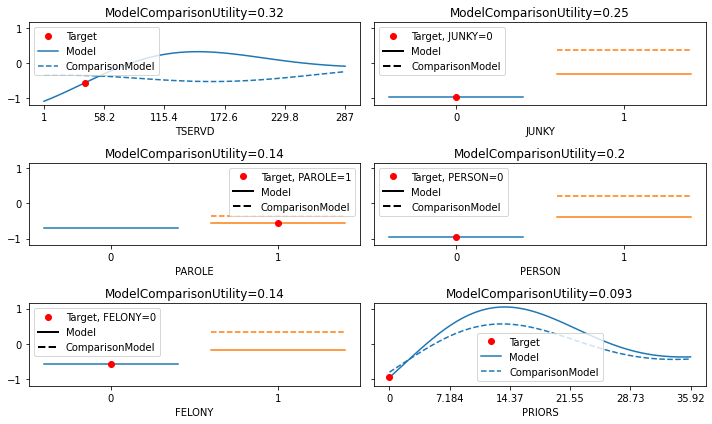

In [6]:
show_flipped_model(feature='WHITE')

{'WHITE': 1.0, 'ALCHY': 0.0, 'JUNKY': 0.0, 'PAROLE': 1.0, 'MARRIED': 0.0, 'FELONY': 0.0, 'WORKREL': 1.0, 'PROPTY': 0.0, 'PERSON': 0.0, 'MALE': 1.0, 'PRIORS': 0.0, 'SCHOOL': 9.0, 'RULE': 7.0, 'AGE (Year)': 22.25, 'TSERVD': 40.0, 'FOLLOW': 52.0}
{'WHITE': 0.0, 'ALCHY': 0.0, 'JUNKY': 0.0, 'PAROLE': 0.0, 'MARRIED': 0.0, 'FELONY': 1.0, 'WORKREL': 1.0, 'PROPTY': 0.0, 'PERSON': 0.0, 'MALE': 1.0, 'PRIORS': 0.0, 'SCHOOL': 13.0, 'RULE': 5.0, 'AGE (Year)': 25.916666666666668, 'TSERVD': 90.0, 'FOLLOW': 57.0}


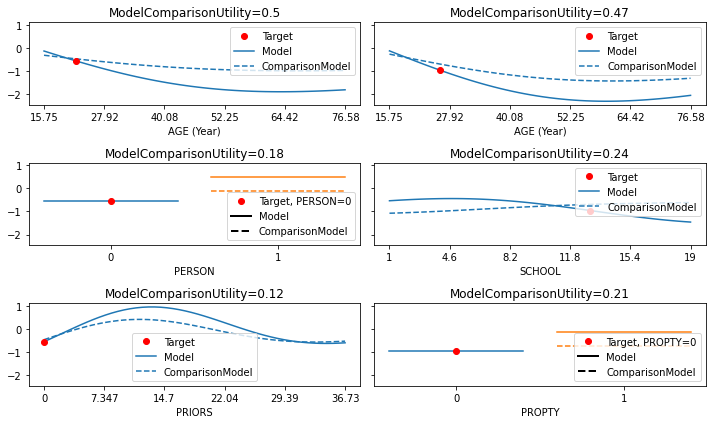

In [7]:
show_flipped_model(feature='MALE')

{'WHITE': 1.0, 'ALCHY': 0.0, 'JUNKY': 0.0, 'PAROLE': 1.0, 'MARRIED': 0.0, 'FELONY': 0.0, 'WORKREL': 1.0, 'PROPTY': 0.0, 'PERSON': 0.0, 'MALE': 1.0, 'PRIORS': 0.0, 'SCHOOL': 9.0, 'RULE': 7.0, 'AGE (Year)': 22.25, 'TSERVD': 40.0, 'FOLLOW': 52.0}


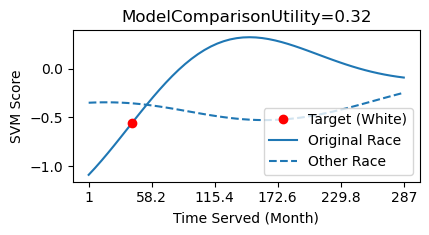

In [8]:
# Figure for paper
show_flipped_model(feature='WHITE', target_idx=[100], max_show=1,
                   figscale=np.array([6, 3.5])*0.7, subplot_kwargs=dict(dpi=100),
                   plot_curve_vals_kwargs=dict(
                       model_label='Original Race', other_model_label='Other Race', target_label='Target (White)',
                   ))
ax = plt.gca()
ax.set_ylabel('SVM Score')
ax.set_xlabel('Time Served (Month)')
plt.savefig('bias-race.pdf', bbox_inches='tight', pad_inches=0)